In [1]:
import sys
import numpy as np
import xarray as xr
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from matplotlib.colors import Normalize
from numba import jit
import seaborn as sns
from utilities import *
from calc_TEM import *
%matplotlib inline

colors=colordefs()
# norm = MidpointNormalize(midpoint=0)
label_size = 12
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 

gw = xr.open_dataset('../pp_data/gw.nc',decode_times=False)['gw'].squeeze()

In [2]:
#constants
H  = 7.0e3 #scale height [m]
a = 6.37e6 #Earth's radius [m]
g  = 9.8 #Acceleration of gravity [m s-2]
om = 7.292e-5  #Rotational rate of Earth in radians per second [s-1]
R = 287.05 #Ideal gas constant
Cp = 1.0035e3 #Specific heat of air at constant pressure

In [3]:
def calc_TEM_from_h0_file(data):
#define constants
    H  = 7.0e3
    a = 6.37e6
    g  = 9.8
    om = 7.292e-5  
    R = 287.05
    Cp = 1.0035e3
    
    print('loading data...')

    #load data from dataset
    P0 = data.P0.values
    time=data.time
    ntime = time.shape[0]
    lat = data.lat
    nlat = lat.shape[0]
    nlon = 4
    phi = np.deg2rad(lat)
    lev = data.lev
    nlev = lev.shape[0]
    ilev = data.ilev
    nilev = ilev.shape[0]
    coslat = np.cos(phi)
    sinlat = np.sin(phi)
    zp = H*np.log(P0/(100*lev))
    zpi = H*np.log(P0/(100*ilev))
    rho = P0/(g*H) * np.exp(-zp/H)

    hyai = data.hyai
    hyam = data.hyam
    hybi = data.hybi
    hybm = data.hybm

    PS = data.PS
    U = data['U']
    U = U.where(U<1e10)
    V = data['V']
    V = V.where(V<1e10)
    OMG = data['OMEGA']
    OMG = OMG.where(OMG<1e10)
    W = (-H/(lev*100)*OMG).transpose('time','lev','lat')
    TH = data['TH']
    TH = TH.where(TH<1e10)
    VTH = data['VTHzm'].squeeze(dim='zlon')
    VTH = VTH.where(VTH<1e10)
    UV = data['UVzm'].squeeze(dim='zlon')
    UV = UV.where(UV<1e10)
    UW = data['UWzm'].squeeze(dim='zlon')
    UW = UW.where(UW<1e10)
    
    print('Finished loading data')
    print('Interpolating...')

    #create dummy DataArray object to hold interpolated variables
    dummy_arr = np.zeros(shape=[ntime,nlev,nlat])
    dummy_out = xr.DataArray(data=dummy_arr,dims=('time','lev','lat'),coords={'time':time,'lev':lev,'lat':lat})
    Up = dummy_out.copy(deep=True)
    Vp = dummy_out.copy(deep=True)
    Wp = dummy_out.copy(deep=True)
    THp = dummy_out.copy(deep=True)
    VTHp = dummy_out.copy(deep=True)
    UVp = dummy_out.copy(deep=True)
    UWp = dummy_out.copy(deep=True)

    Up[:] = Ngl.vinth2p(np.broadcast_to(U.values[...,None],U.shape+(nlon,)),hyam.values,hybm.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    Vp[:] = Ngl.vinth2p(np.broadcast_to(V.values[...,None],V.shape+(nlon,)),hyam.values,hybm.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    Wp[:] = Ngl.vinth2p(np.broadcast_to(W.values[...,None],W.shape+(nlon,)),hyam.values,hybm.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    THp[:] = Ngl.vinth2p(np.broadcast_to(TH.values[...,None],TH.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    VTHp[:] = Ngl.vinth2p(np.broadcast_to(VTH.values[...,None],VTH.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    UVp[:] = Ngl.vinth2p(np.broadcast_to(UV.values[...,None],UV.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    UWp[:] = Ngl.vinth2p(np.broadcast_to(UW.values[...,None],UW.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)

    print('Finished interpolating')
    print('Calculating TEM terms')
    
     #calculate d\bar\theta/dz
    thbar_z = dummy_out.copy(deep=True)
    thbar_z[:] = np.gradient(THp,zp,axis=-2,edge_order=2)

    thbar_z.values[(thbar_z<1e-4).values]=1e-4 #put floor on thbar_z. Do not know why but from NCAR script


    print('Calculating wbar*')
    #calculate wbar*
    derivand=(coslat*VTHp/thbar_z).transpose('time','lev','lat')
    derivative = dummy_out.copy(deep=True)
    derivative[:] = np.gradient(derivand,phi,axis=-1,edge_order=2)
    d2y = dummy_out.copy(deep=True)
    d2y[:] = np.gradient(derivative,phi,axis=-1)

    wstar = Wp+derivative/(a*coslat)
    wstar[:,:,0] = Wp[:,:,0]-(1./(a*sinlat[0]))*d2y[:,:,0]
    wstar[:,:,-1] = Wp[:,:,-1]-(1./(a*sinlat[-1]))*d2y[:,:,-1]
    
    print('Calculating vbar*')
    #calculate vbar*
    derivand = (rho*VTHp/thbar_z).transpose('time','lev','lat')
    derivative = dummy_out.copy(deep=True)
    derivative[:] = np.gradient(derivand,zp,axis=-2,edge_order=2)
    vstar = Vp-derivative
    
    print('Calculating EP-flux')
    #calculate EP-flux
    fc = 2.*om*sinlat
    ubar_z = dummy_out.copy(deep=True)
    ubar_z[:] = np.gradient(Up,zp,axis=-2,edge_order=2)
    ubar_y = dummy_out.copy(deep=True)
    ucoslat = (Up*coslat).transpose('time','lev','lat')
    ubar_y[:] = (np.gradient(ucoslat.values,phi.values,axis=-1))
    ubar_y = (ubar_y/(a*coslat)).transpose('time','lev','lat')
    fy = dummy_out.copy(deep=True)
    fz = dummy_out.copy(deep=True)
    fy[:] = ((ubar_z*VTHp/thbar_z-UVp)*rho*a*coslat).transpose('time','lev','lat')
    fy[...,0] = 0.0
    fy[...,-1] = 0.0
    fz[:] = ((fc-ubar_y*VTHp/thbar_z-UWp)*rho*a*coslat).transpose('time','lev','lat')
    fz[...,0] = 0.0
    fz[...,-1] = 0.0
    
    print('Calculating divergence of EP-flux')
    
    fycoslat = (coslat*fy).transpose('time','lev','lat')
    fyy = dummy_out.copy(deep=True)
    fyy[:] = np.gradient(fycoslat,phi,axis=-1)
    fyy = (1/(a*coslat)*fyy).transpose('time','lev','lat')
    fyy = (fyy/(a*rho*coslat)).transpose('time','lev','lat')
    
    fyy[...,0] = 0.0
    fyy[...,-1] = 0.0
    
    fzz = dummy_out.copy(deep=True)
    fzz[:] = np.gradient(fz,zp,axis=-2)
    fzz = (fzz/(a*rho*coslat)).transpose('time','lev','lat')
    
    fzz[...,0] = 0.0
    fzz[...,-1] = 0.0
    
    print('Finished')
    return wstar,vstar,fy,fz,fyy,fzz,Wp

In [5]:
ctrzon = xr.open_dataset('../pp_data/bwma1850.f09.y30.los_chocoyos.qboW.ensoN.SO2.cam.h0.0030-0064.zonmean.nc',decode_times=False)
# ctrzon.time.values = (ctrzon.time.values-ctrzon.time.values[0])/365
# ctrzon.time.values
ctrzon.time.values = np.arange(ctrzon.time.shape[0])/12.
# ctrzon = ctrzon.sel(time=slice(5,100))
# ctrzon.time.values = np.arange(ctrzon.time.shape[0])/12.
# ctrzon.time.values = (ctrzon.time.values-ctrzon.time.values[0])


climzon = xr.open_dataset('../pp_data/bwma1850.f09.test1.cam.h0.year.zonmean.nc',decode_times=False)
climT = climzon['T']

In [6]:
ctrTanom = get_anomaly_v2(ctrzon['T'],climT)

In [7]:
days = return_day_array(ctrTanom.time)

In [8]:
dT_anomdt = differentiate_DA(ctrTanom,days)

In [9]:
dT_anomdt_trop = dT_anomdt.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [10]:
wstar,vstar,fy,fz,fyy,fzz,Wp = calc_TEM_from_h0_file(ctrzon)

loading data...
Finished loading data
Interpolating...
Finished interpolating
Calculating TEM terms
Calculating wbar*
Calculating vbar*
Calculating EP-flux
Calculating divergence of EP-flux
Finished


In [11]:
divF = fyy+fzz
divF_trop = divF.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [12]:
wtrop = wstar.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [13]:
Wtrop = Wp.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [14]:
U = ctrzon['U']
U_trop = U.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [15]:
dudt = differentiate_DA(U_trop,days)

In [17]:
phi = np.deg2rad(vstar.lat.values)
dUdy = 1/(a*np.cos(phi))*differentiate_DA_lat(a*ctrzon['U']*np.cos(phi))

In [18]:
vdUdy = -vstar*dUdy
vdUdy_trop = vdUdy.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [19]:
VdUdy = -ctrzon['V']*dUdy
VdUdy_trop = VdUdy.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [20]:
dudz = differentiate_DA_z(U_trop)

In [21]:
f = 2*om*np.sin(phi)
cor = (vstar*f).sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [22]:
f = 2*om*np.sin(phi)
Vcor = (ctrzon['V']*f).sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [23]:
test=sns.diverging_palette(255,15,sep=1,s=99,l=40,as_cmap=True)

In [25]:
from plot_qbo_with_cs import *

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


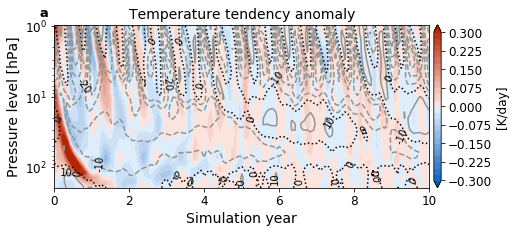

In [26]:
qbo_plot_with_cs(dT_anomdt_trop,U_trop,cf_levels=np.linspace(-0.3,0.3,25),cs_levels=np.linspace(-40,40,9),xlabel='Simulation year',clblabel='[K/day]',title='Temperature tendency anomaly')
plt.gca().text(-0.04,1.05,'a',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboW_QBO_dTdt.png',dpi=300,bbox_inches='tight')

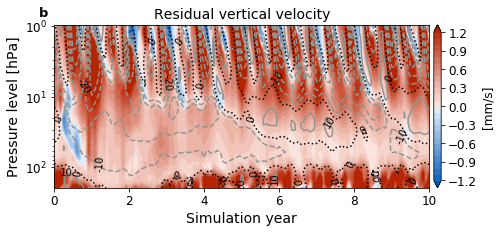

In [27]:
qbo_plot_with_cs(1000*wtrop,U_trop,cf_levels=np.linspace(-1.2,1.2,25),xlabel='Simulation year',clblabel='[mm/s]',title='Residual vertical velocity')
plt.gca().text(-0.04,1.05,'b',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboW_QBO_ws.png',dpi=300,bbox_inches='tight')

In [28]:
Uctr = ctrzon['U'].sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [29]:
dUdt = Uctr.copy(deep=True)
dUdt[:] = 0.0
dUdt[:] = np.gradient(Uctr,days,axis=0,edge_order=2)

In [30]:
gwd = (ctrzon['UTGWORO'].sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2))) + 
       ctrzon['UTGWSPEC'].sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2))) + 
       ctrzon['BUTGWSPEC'].sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2))))

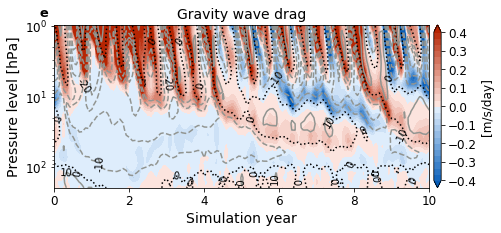

In [31]:
qbo_plot_with_cs(86400*gwd,U_trop,cf_levels=np.linspace(-0.4,0.4,25),xlabel='Simulation year',title='Gravity wave drag',clblabel='[m/s/day]')
plt.gca().text(-0.04,1.05,'e',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboW_QBO_gwd.png',dpi=300,bbox_inches='tight')

In [32]:
#calculate -w* * du/dz
z = 7e3*np.log(ctrzon.P0.values/(100*ctrzon.lev))
dudz = Uctr.copy(deep=True)
dudz[:] = np.gradient(Uctr.values,z,axis=-1,edge_order=2)
wdudz = -wtrop*dudz.values

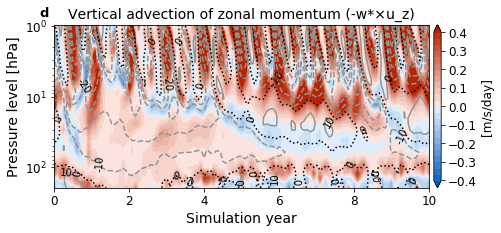

In [33]:
qbo_plot_with_cs(86400*wdudz,U_trop,cf_levels=np.linspace(-0.4,0.4,25),xlabel='Simulation year',title='Vertical advection of zonal momentum (-w*×u_z)',clblabel='[m/s/day]')
plt.gca().text(-0.04,1.05,'d',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboW_QBO_wdudz.png',dpi=300,bbox_inches='tight')

In [34]:
vtrop = vstar.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

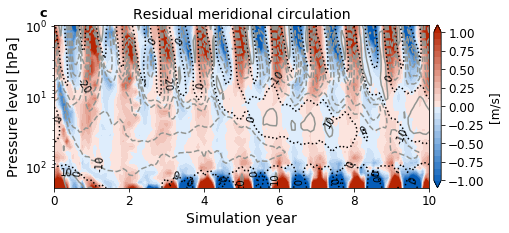

In [35]:
qbo_plot_with_cs(vtrop,U_trop,cf_levels=np.linspace(-1,1,25),xlabel='Simulation year',title='Residual meridional circulation',clblabel='[m/s]')
plt.gca().text(-0.04,1.05,'c',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboW_QBO_vs.png',dpi=300,bbox_inches='tight')

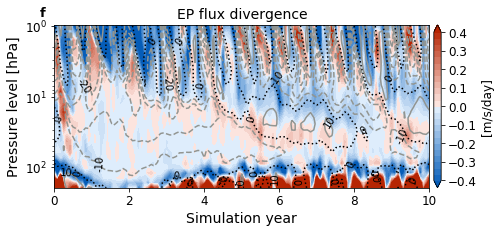

In [36]:
qbo_plot_with_cs(86400*divF_trop,U_trop,cf_levels=np.linspace(-0.4,0.4,25),xlabel='Simulation year',title='EP flux divergence',clblabel='[m/s/day]')
plt.gca().text(-0.04,1.05,'f',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('LCY_sulf.qboW_QBO_divF.png',dpi=300,bbox_inches='tight')

In [38]:
! gm montage -geometry +2+2 -tile 2x3 LCY_sulf.qboW_QBO_dTdt.png LCY_sulf.qboW_QBO_ws.png LCY_sulf.qboW_QBO_vs.png LCY_sulf.qboW_QBO_wdudz.png LCY_sulf.qboW_QBO_gwd.png LCY_sulf.qboW_QBO_divF.png LCY_sulf.qboW_QBO_TEM_terms.png